# First try at creating an AI

[Tutorial](https://www.tensorflow.org/tutorials/keras/regression#regression_with_a_deep_neural_network_dnn)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow import keras
from keras import layers

In [2]:
raw_df = pd.read_csv("Receipts August 2022 - V5.csv")
raw_df['date'] = pd.to_datetime(raw_df['date'], format='%d-%m-%Y')
raw_df['time of exit'] = pd.to_datetime(raw_df['time of exit'], format='%H:%M:%S')

clean_df = pd.DataFrame()
# clean_df['id'] = raw_df['id'] Dont need this column
clean_df['day of week'] = raw_df['date'].dt.day_of_week
clean_df['toe hour'] = raw_df['time of exit'].dt.hour
clean_df['toe minute'] = raw_df['time of exit'].dt.minute
clean_df['total'] = raw_df['total']

df = clean_df.copy()
df.tail()

,day of week,toe hour,toe minute,total
170,5,16,37,16.50
171,3,20,19,38.45
172,3,20,14,57.00
173,6,17,24,75.00
174,6,17,3,27.20


In [3]:
# Randomizing order of rows
df = df.sample(frac=1).reset_index(drop=True)
df.tail()

,day of week,toe hour,toe minute,total
170,2,20,58,71.30
171,4,18,8,55.00
172,2,18,9,54.50
173,4,20,7,50.50
174,2,17,10,36.95


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   day of week  175 non-null    int64  
 1   toe hour     175 non-null    int64  
 2   toe minute   175 non-null    int64  
 3   total        175 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 5.6 KB


In [5]:
df.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
day of week,175.0,3.554286,1.740713,1.0,2.0,4.0,5.000,6.00
toe hour,175.0,18.285714,1.393157,14.0,17.0,19.0,19.000,21.00
toe minute,175.0,29.274286,17.137181,0.0,15.0,28.0,43.500,59.00
total,175.0,45.365429,22.169354,10.0,26.3,46.4,57.375,99.95


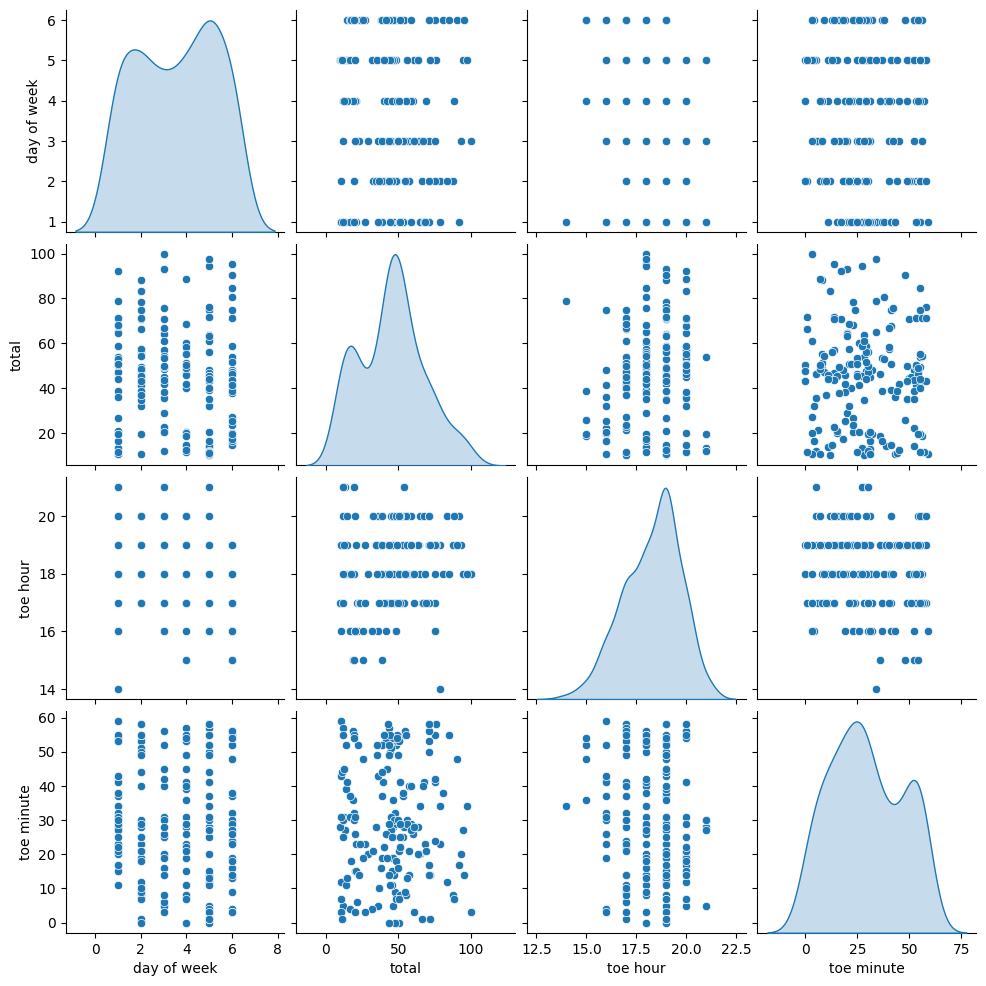

In [6]:
sns.pairplot(df[['day of week', 'total', 'toe hour', 'toe minute']], diag_kind='kde')

In [7]:
df_training = df.head(150)
df_testing = df.tail(25)

In [8]:
df_training_features = df_training.copy()
df_testing_features = df_testing.copy()

df_training_labels = df_training_features.pop('total')
df_testing_labels = df_testing_features.pop('total')

In [9]:
df_training.describe().transpose()[['mean', 'std']]

,mean,std
day of week,3.620000,1.748134
toe hour,18.280000,1.386028
toe minute,29.086667,17.243591
total,45.121667,22.127866


## AI time!

In [10]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(df_training_features))
print(normalizer.mean.numpy())

[[ 3.62     18.28     29.086666]]


In [11]:
first = np.array(df_training_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[ 4 16 23]]

Normalized: [[ 0.22 -1.65 -0.35]]


### Linear regression: predict `total` from `day of week` 

In [12]:
dow = np.array(df_training['day of week'])

dow_normalizer = layers.Normalization(input_shape=[1,], axis=None)
dow_normalizer.adapt(dow)

In [13]:
dow_model = tf.keras.Sequential([
    dow_normalizer,
    layers.Dense(units=1)
])

dow_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [14]:
dow_model.predict(dow[:10])

1/1 [==============================] - 0s 69ms/step


array([[-0.1413299 ],
       [ 0.9744321 ],
       [ 0.23059078],
       [ 0.9744321 ],
       [ 0.60251147],
       [ 0.9744321 ],
       [-0.5132505 ],
       [-0.5132505 ],
       [ 0.9744321 ],
       [ 0.23059078]], dtype=float32)

In [15]:
dow_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [16]:
# %%time
history = dow_model.fit(
    df_training_features['day of week'],
    df_training_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

In [17]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,21.763147,24.228758,95
96,21.645784,24.081707,96
97,21.541573,23.938099,97
98,21.435818,23.797115,98
99,21.328800,23.660089,99


In [18]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([15, 50])
  plt.xlabel('Epoch')
  plt.ylabel('Error [total]')
  plt.legend()
  plt.grid(True)

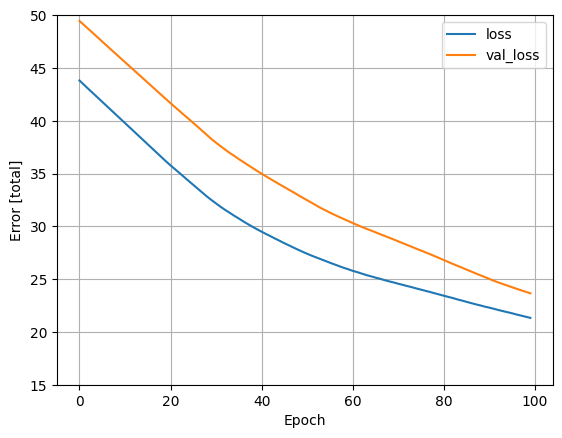

In [19]:
plot_loss(history)

In [20]:
test_results = {}

test_results['dow_model'] = dow_model.evaluate(
    df_testing_features['day of week'],
    df_testing_labels, verbose=0)

In [21]:
x = tf.linspace(0, 7, 8)
y = dow_model.predict(x)

1/1 [==============================] - 0s 34ms/step


In [22]:
def plot_dow(x, y):
  plt.scatter(df_training_features['day of week'], df_training_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Day of week')
  plt.ylabel('Total')
  plt.legend()

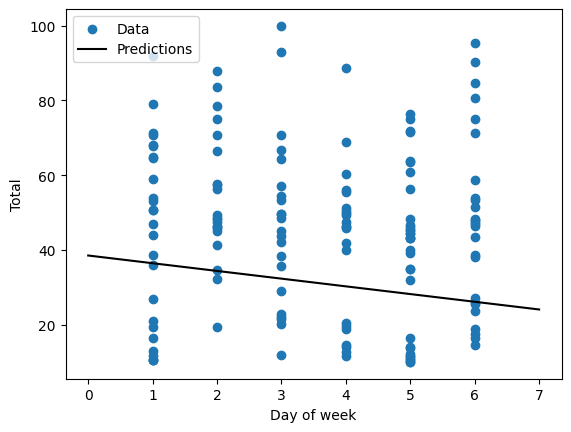

In [23]:
plot_dow(x, y)

### Linear regression: predict `total` from `day of week` AND `hour of exit`?

Linear regression with multiple inputs

In [24]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [25]:
linear_model.predict(df_training_features[:10]) # :10 == take first 10 columns from col id 0. 3:9 == col 3 to 8

1/1 [==============================] - 0s 33ms/step


array([[ 0.62855434],
       [-0.35150075],
       [ 0.02555683],
       [-0.27802163],
       [-0.36067906],
       [-0.49845895],
       [ 0.6175382 ],
       [ 0.34061304],
       [ 0.46963465],
       [-0.05159801]], dtype=float32)

In [26]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(3, 1) dtype=float32, numpy=
array([[ 0.21044958],
       [-0.28357917],
       [-0.32359976]], dtype=float32)>

In [27]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [28]:
# %%time
history = linear_model.fit(
    df_training_features,
    df_training_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

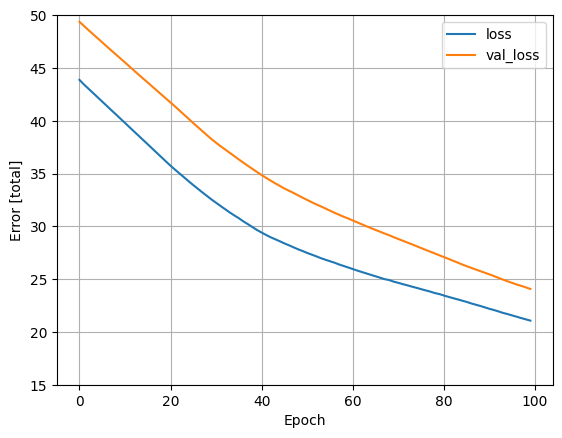

In [29]:
plot_loss(history)

In [30]:
test_results['linear_model'] = linear_model.evaluate(
    df_testing_features, df_testing_labels, verbose=0)

## Deep Neural Networks (DNN)

In [31]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### DNN with single input (`day of week`)

In [32]:
dnn_dow_model = build_and_compile_model(dow_normalizer)

In [33]:
dnn_dow_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [34]:
# %%time
history = dnn_dow_model.fit(
    df_training_features['day of week'],
    df_training_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

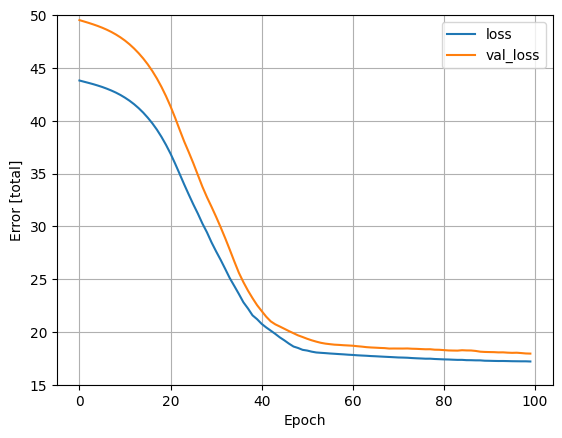

In [35]:
plot_loss(history)

Note: This chart looks different from the previous ones and from the one in the tutorial

In [36]:
x = tf.linspace(0, 7, 8)
y = dnn_dow_model.predict(x)

1/1 [==============================] - 0s 40ms/step


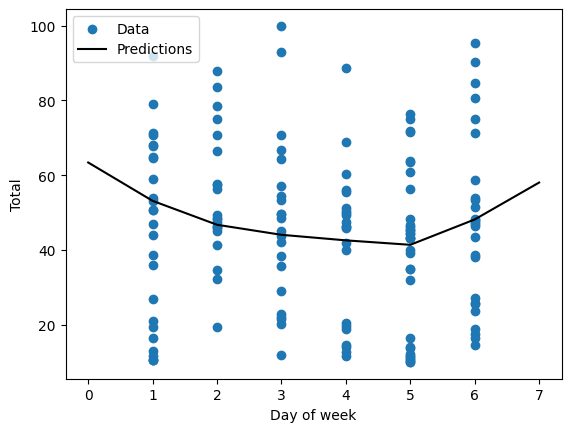

In [37]:
plot_dow(x, y)

This chart, again, is different and follows the dots a bit more. Curious to see what happens when executed on a different data combination. Day of week only provides 6 points.

In [38]:
test_results['dnn_dow_model'] = dnn_dow_model.evaluate(
    df_testing_features['day of week'], df_testing_labels,
    verbose=0)

### DNN with multiple inputs (`all...?`)

In [39]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                256       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,488
Trainable params: 4,481
Non-trainable params: 7
_________________________________________________________________


In [40]:
# %%time
history = dnn_model.fit(
    df_training_features,
    df_training_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

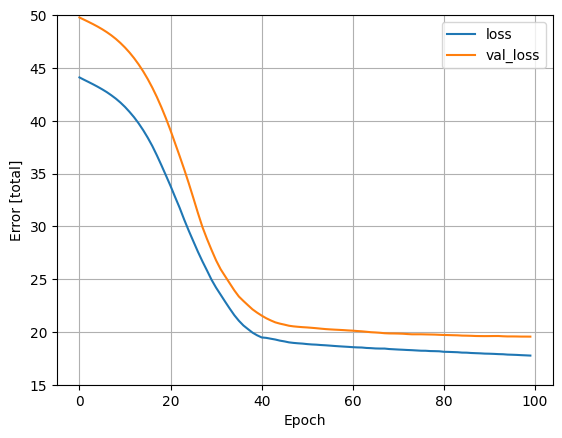

In [41]:
plot_loss(history)

In [42]:
test_results['dnn_model'] = dnn_model.evaluate(df_testing_features, df_testing_labels, verbose=0)

## Comparing the models

In [43]:
pd.DataFrame(test_results, index=['Mean absolute error [total]']).T

,Mean absolute error [total]
dow_model,21.245852
linear_model,20.447765
dnn_dow_model,18.060465
dnn_model,20.335670


1/1 [==============================] - 0s 39ms/step


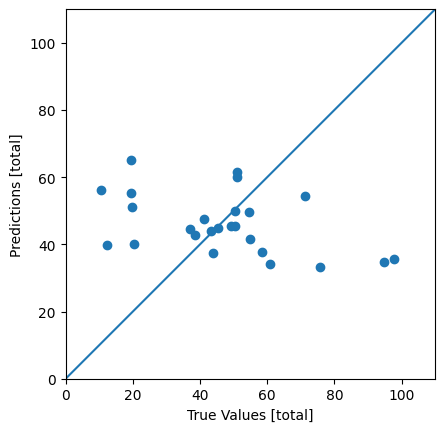

In [44]:
test_predictions = dnn_model.predict(df_testing_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(df_testing_labels, test_predictions)
plt.xlabel('True Values [total]')
plt.ylabel('Predictions [total]')
lims = [0, 110]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

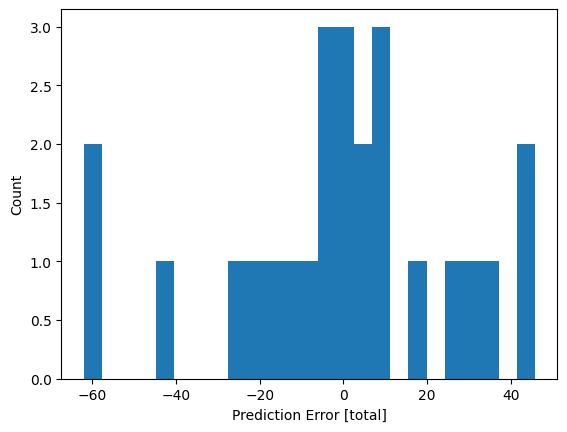

In [45]:
error = test_predictions - df_testing_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [total]')
_ = plt.ylabel('Count')

In [46]:
dnn_model.save('dnn_model_first_try')

INFO:tensorflow:Assets written to: dnn_model_first_try\assets


## Next up:
* Back to EDA to find new correlation to create a model for. One that has a clear correlation
* Set up the data correctly
* Use [conclusions](https://www.tensorflow.org/tutorials/keras/regression#conclusion) and everything else i've learned in a second try!